# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [1]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm

## Read data 

In [2]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

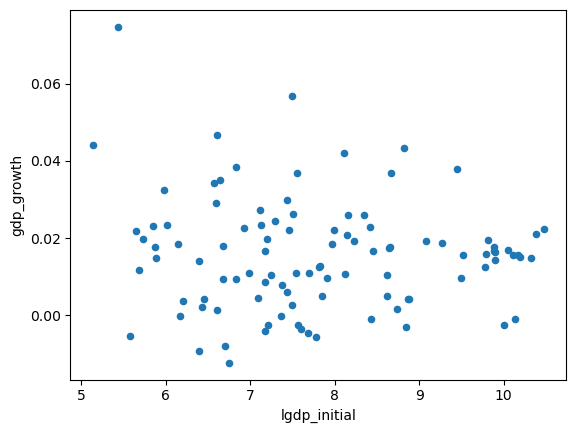

In [3]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth');

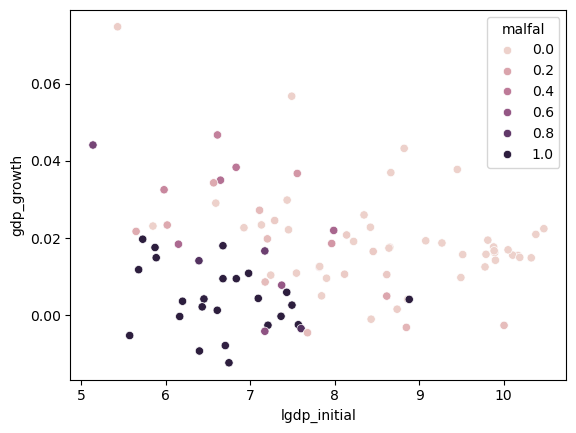

In [4]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [5]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demreg'] 
#vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


In [6]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))

In [7]:
dat.isnull().sum() # check for missing values

code              0
marketref        78
dem              59
demCGV           64
demBMR           60
               ... 
gdp_growth      112
pop_growth       16
lgdp_initial    105
lpop_initial     15
constant          0
Length: 86, dtype: int64

# Simple OLS

In [8]:
# 1. avoiding missings 
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)

# 2. extract dataset 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, ['constant','lgdp_initial']].values

# 3. run OLS
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

[[ 2.24792211]
 [-0.08713416]]


# Adding more controls

In [9]:
vs = vv_all['geography'] + vv_all['religion']
xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
X = np.hstack([X, oo])
xs.append('constant') # we put it in as the last element

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X.T @ X) @ X.T @ y

In [10]:
# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'β': betas[:,0]}, index=xs).round(3)

Mean y =  1.52% growth per year


,β
lgdp_initial,-1.118
pop_growth,6.830
investment_rate,0.068
tropicar,-0.411
distr,-0.000
distcr,0.001
distc,-0.003
suitavg,-1.063
temp,-0.204
suitgini,-0.771


### Penalities

#### BCCH

In [ ]:
# BCCH penalty:
def BCCH(X_stan,y):
    n,p = X_stan.shape
    c = 1.1
    alpha = 0.05

    yXscale = (np.max((X_stan.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
    penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yXscale

    pred = Lasso(alpha=penalty_pilot).fit(X_stan,y).predict(X_stan)

    eps = y - pred 
    epsXscale = (np.max((X_stan.T ** 2) @ (eps ** 2) / n)) ** 0.5
    penalty_BCCH = c*norm.ppf(1-alpha/(2*p))*epsXscale/np.sqrt(n)

    return penalty_BCCH


#### CV

In [ ]:
# CV penalty:
def CV(X_stan,y):
    fit_CV = LassoCV(cv=5).fit(X_stan,y)

    # Investigate the penalty
    penalty_CV = fit_CV.alpha_

    return penalty_CV

## POST DOUBLE LASSO

In [34]:
#adding the extra chosen control variables:
z =vv_all['geography'] + vv_all['institutions'] + ['investment_rate','pop_growth']
d = ['lgdp_initial']
x = d + z

# avoiding missings
all_vars = ['gdp_growth'] + x
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, x].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%
Z = dat.loc[I,z].values
D = dat.loc[I,d].values 

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

In [35]:
# Create a function for standardizing
def standardize(X):
    X_stan = (X - np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)
    return X_stan

# Standardize data
X_stan = standardize(X)
Z_stan = standardize(Z)
D_stan = standardize(D)

n,p = X_stan.shape

### PDL BCCH penalty

Step 1: Lasso Y using D and Z (in X)

In [36]:
# Calculate BRT
penalty_BCCHyx = BCCH(X_stan, y)
print("lambda_BCCHyx =",penalty_BCCHyx.round(2))

# Run Lasso 
fit_BCCHyx = Lasso(penalty_BCCHyx, max_iter=10000).fit(X_stan, y)
coefs=fit_BCCHyx.coef_

# Calculate residuals
resyx = y-fit_BCCHyx.predict(X_stan)

# Calculate Y - Z@gamma (epsilon + alpha*d)
# Hint: You only need the variables given to you in this cell, in addition
# to a standardized data set you made previoously.
resyxz = resyx + D_stan*coefs[0]

# Display first coefficient
print("First coefficient =",coefs[0].round(5))

lambda_BCCHyx = 1.17
First coefficient = -0.0


Step 2: Lasso D using Z

In [37]:
penalty_BCCHdz = BCCH(Z_stan, D)
print("lambda_BCCHdz =",penalty_BCCHdz.round(2))

# Run Lasso
fit_BCCHdz = Lasso(penalty_BCCHdz, max_iter=10000).fit(Z_stan, D)
coefs=fit_BCCHdz.coef_

# Calculate residuals
resdz=D-fit_BCCHdz.predict(Z_stan)

# Display first coefficient
print("First coefficient =",coefs[0].round(5))

lambda_BCCHdz = 0.91
First coefficient = -0.0


In [38]:
# Calculate alpha
num = resdz@resyxz
denom = resdz@D
alpha_PDL = num/denom

# Display alpha
print("alpha_PDL = ",alpha_PDL.round(3))

alpha_PDL =  [[-0.    -0.    -0.    ... -0.    -0.    -0.   ]
 [-0.    -0.    -0.    ... -0.    -0.    -0.   ]
 [-0.    -0.    -0.    ... -0.    -0.    -0.   ]
 ...
 [-0.001 -0.001 -0.001 ... -0.001 -0.001 -0.001]
 [ 0.001  0.001  0.001 ...  0.001  0.001  0.001]
 [ 0.001  0.001  0.001 ...  0.001  0.001  0.001]]


In [39]:
# Calculate variance    
num = resdz**2@resyx**2/n
denom = (resdz.T@resdz/n)**2
sigma2_PDL = num/denom

# Display variance
print("sigma2_PDL = ",sigma2_PDL.round(3))

sigma2_PDL =  [[0.555 0.555 0.555 ... 0.555 0.555 0.555]
 [2.929 2.929 2.929 ... 2.929 2.929 2.929]
 [2.243 2.243 2.242 ... 2.243 2.243 2.243]
 ...
 [0.424 0.424 0.424 ... 0.424 0.424 0.424]
 [0.134 0.134 0.134 ... 0.134 0.134 0.134]
 [0.258 0.258 0.258 ... 0.258 0.258 0.258]]


In [40]:
# Calculate standard error
se_PDL = np.sqrt(sigma2_PDL/n)

# Display standard error
print("se_PDL = ",se_PDL.round(3))

se_PDL =  [[0.085 0.085 0.085 ... 0.085 0.085 0.085]
 [0.196 0.196 0.196 ... 0.196 0.196 0.196]
 [0.172 0.172 0.172 ... 0.172 0.172 0.172]
 ...
 [0.075 0.075 0.075 ... 0.075 0.075 0.075]
 [0.042 0.042 0.042 ... 0.042 0.042 0.042]
 [0.058 0.058 0.058 ... 0.058 0.058 0.058]]


In [41]:
# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_PDL  = alpha_PDL - q * se_PDL
CI_high_PDL = alpha_PDL + q * se_PDL

# Display confidence interval
print("CI_PDL = ",(CI_low_PDL.round(2),CI_high_PDL.round(3)))

CI_PDL =  (array([[-0.17, -0.17, -0.17, ..., -0.17, -0.17, -0.17],
       [-0.38, -0.38, -0.38, ..., -0.38, -0.38, -0.38],
       [-0.34, -0.34, -0.34, ..., -0.34, -0.34, -0.34],
       ...,
       [-0.15, -0.15, -0.15, ..., -0.15, -0.15, -0.15],
       [-0.08, -0.08, -0.08, ..., -0.08, -0.08, -0.08],
       [-0.11, -0.11, -0.11, ..., -0.11, -0.11, -0.11]]), array([[0.167, 0.167, 0.167, ..., 0.167, 0.167, 0.167],
       [0.385, 0.385, 0.385, ..., 0.385, 0.385, 0.385],
       [0.336, 0.336, 0.336, ..., 0.336, 0.337, 0.336],
       ...,
       [0.146, 0.146, 0.146, ..., 0.146, 0.146, 0.146],
       [0.083, 0.083, 0.083, ..., 0.083, 0.083, 0.083],
       [0.115, 0.115, 0.115, ..., 0.115, 0.115, 0.115]]))


In [42]:
# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'β': alpha_PDL[:, 0][:28]}, index=xs).round(3)

#pd.DataFrame({'β': alpha_PDL[:,0]}, index=x).round(3)

Mean y =  1.52% growth per year


,β
lgdp_initial,-0.000
pop_growth,-0.000
investment_rate,-0.000
tropicar,-0.000
distr,0.000
distcr,0.000
distc,0.001
suitavg,-0.001
temp,0.000
suitgini,-0.001


### PDL CV Penalty

In [44]:
# Calculate BRT
penalty_CVyx = CV(X_stan, y)

# Run Lasso 
fit_CVyx = Lasso(penalty_CVyx, max_iter=10000).fit(X_stan, y)
coefs=fit_CVyx.coef_

# Calculate residuals
resyx = y-fit_CVyx.predict(X_stan)

# Calculate Y - Z@gamma (epsilon + alpha*d)
# Hint: You only need the variables given to you in this cell, in addition
# to a standardized data set you made previoously.
resyxz = resyx + D_stan*coefs[0]

# Display first coefficient
print("First coefficient =",coefs[0].round(5))

First coefficient = -1.40564


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
penalty_CVdz = CV(Z_stan, D)
print("lambda_BCCHdz =",penalty_CVdz.round(2))

# Run Lasso
fit_CVdz = Lasso(penalty_CVdz, max_iter=10000).fit(Z_stan, D)
coefs=fit_CVdz.coef_

# Calculate residuals
resdz=D-fit_CVdz.predict(Z_stan)

# Display first coefficient
print("First coefficient =",coefs[0].round(5))

lambda_BCCHdz = 0.03
First coefficient = -0.0409


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
# Calculate alpha
num = resdz@resyxz
denom = resdz@D
alpha_PDL = num/denom

# Display alpha
#print("alpha_PDL = ",alpha_PDL.round(3))

# Calculate variance    
num = resdz**2@resyx**2/n
denom = (resdz.T@resdz/n)**2
sigma2_PDL = num/denom

# Display variance
#print("sigma2_PDL = ",sigma2_PDL.round(3))

# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_PDL  = alpha_PDL - q * se_PDL
CI_high_PDL = alpha_PDL + q * se_PDL

# Display confidence interval
#print("CI_PDL = ",(CI_low_PDL.round(2),CI_high_PDL.round(3)))

pd.DataFrame({'β': alpha_PDL[:, 0][:28]}, index=xs).round(3)

,β
lgdp_initial,0.236
pop_growth,0.104
investment_rate,0.117
tropicar,0.116
distr,-0.106
distcr,-0.054
distc,-0.196
suitavg,0.450
temp,-0.084
suitgini,0.487
